In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
Base = automap_base()

# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\bkeut\anaconda3\envs\PythonData\lib\site-packages\sqlalchemy\ext\declarative\clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)
C:\Users\bkeut\anaconda3\envs\PythonData\lib\site-packages\sqlalchemy\ext\declarative\clsregistry.py:129: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  % (item.__module__, item.__name__)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The most recent date in the data set is {recent_date}.")


The most recent date in the data set is 2017-08-23.


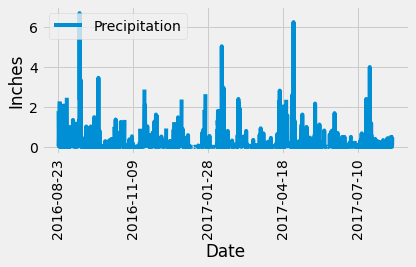

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = (dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=365)).strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
# use the session to query the total number of stations
total_stations = session.query(func.count(func.distinct(Measurement.station))).scalar()

# print the result
print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Query to get the count of measurements for each station
station_counts = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).all()

# Sort the stations by measurement count in descending order
sorted_stations = sorted(station_counts, key=lambda x: x[1], reverse=True)

# Print the sorted stations with their measurement counts
for station in sorted_stations:
    print(f"Station {station[0]}: {station[1]} measurements")
    
# Get the station with the most measurements
most_active_station = sorted_stations[0][0]

# Using the most active station id, calculate the lowest, highest, and average temperature
temperatures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

# Print the results
print(f"Lowest temperature at Station {most_active_station}: {temperatures[0][0]}")
print(f"Highest temperature at Station {most_active_station}: {temperatures[0][1]}")
print(f"Average temperature at Station {most_active_station}: {temperatures[0][2]}")

Station USC00519281: 2772 measurements
Station USC00519397: 2724 measurements
Station USC00513117: 2709 measurements
Station USC00519523: 2669 measurements
Station USC00516128: 2612 measurements
Station USC00514830: 2202 measurements
Station USC00511918: 1979 measurements
Station USC00517948: 1372 measurements
Station USC00518838: 511 measurements
Lowest temperature at Station USC00519281: 54.0
Highest temperature at Station USC00519281: 85.0
Average temperature at Station USC00519281: 71.66378066378067


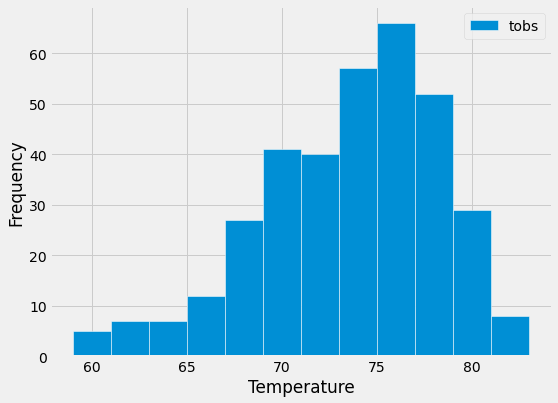

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Define the most active station ID
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count().desc()).\
    first()[0]

# Calculate the date one year ago from the last data point in the database
last_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    first()[0]
year_ago_date = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for this station
results = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= year_ago_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['tobs'])

# Plot the results as a histogram
df.plot.hist(bins=12, figsize=(8,6), edgecolor='white')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


# Close session

In [16]:
# Close Session
session.close()